# GLM: Poisson Regression

In [87]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from PIL import Image
from theano import shared
import arviz as az
from scipy.special import expit as logistic
import theano.tensor as tt

#### Binomial models are great when the outcome is between zero and some known value. The binomial model can work when the upper bound is not known, when $p$ is small and $N$ is large then $\mu$ and $\sigma$ are approximately the same.

In [2]:
y = np.random.binomial(n=1_000, p=1/1_000, size=10_000)
print(np.mean(y), np.var(y))

0.9883 0.9995631100000002


#### This is a special shape of the binomial. This special shape is known as the Poisson distribution, and it is useful because it allows us to model binomial events for which the number of trials N is unknown or uncountably large. It also implies an exponential relationship between predictors and the expected value. Exponential relationships grow very quickly, and few natural phenomena can remain exponential for long. So one thing to always check with a log link is whether it makes sense at all ranges of the predictor variables. The priors on the log scale also scale in surprising ways. So prior predictive simulation is again helpful.

#### When building a Poisson model we generally use a log link function as it ensures that $\lambda_{i}$ is always positive:
$$y_{i} \sim Poisson(\lambda_{i})$$

$$log(\lambda_{i}) = \alpha + \beta(x_{i} - \bar{x})$$

#### Data: Oceanic tool complexity
#### The island societies of Oceania provide a natural experiment in technological evolution. Different historical island populations possessed tool kits of different size. These kits include fish hooks, axes, boats, hand plows, and many other types of tools. A number of theories predict that larger populations will both develop and sustain more complex tool kits. So the natural variation in population size induced by natural variation in island size in Oceania provides a natural experiment to test these ideas. It’s also suggested that contact rates among populations effectively increase population size, as it’s relevant to technology.

In [51]:
def data_proc():
    
    def standardise(x):
        return (x-x.mean())/x.std()
    
    data = pd.read_csv(os.path.join(os.getcwd(),r'data/Kline.csv'), delimiter=";")
    data["P"] = standardise(np.log(data['population']))
    data["cid"] = (data['contact']=='high').astype(int)
    
    return data

In [52]:
d = data_proc()

In [5]:
d

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


#### Keep in mind that the number of rows is not clearly the same as the “sample size” in a count model. The relationship between parameters and “degrees of freedom” is not simple, outside of simple linear regressions. Still, there isn’t a lot of data here, because there just aren’t that many historic Oceanic societies for which reliable data can be gathered. We’ll want to use regularization to damp down overfitting, as always. But as you’ll see, a lot can still be learned from these data. Any rules you’ve been taught about minimum sample sizes for inference are just non-Bayesian superstitions. If you get the prior back, then the data aren’t enough. It’s that simple.

#### The total_tools variable will be the outcome variable. We’ll model the idea that:
##### (1) The number of tools increases with the log population size. Why log? Because that’s what the theory says, that it is the order of magnitude of the population that matters, not the absolute size of it. So we’ll look for a positive association between total_tools and log population. You can get some intuition for why a linear impact of population size can’t be right by thinking about mechanism. We’ll think about mechanism more at the end.
##### (2) The number of tools increases with the contact rate among islands. No nation is an island, even when it is an island. Islands that are better networked may acquire or sustain more tool types.
##### (3) The impact of population on tool counts is moderated by high contact. This is to say that the association between total_tools and log population depends upon contact. So we will look for a positive interaction between log population and contact rate.

#### Initial model structure:
$$T_{i} \sim Poisson(\lambda_{i})$$
$$log(\lambda_{i}) = \alpha_{CID[i]} + \beta_{CID[i]}log(P_{i})$$
$$\alpha_{j} \sim TBD$$
$$\beta_{j} \sim TBD$$ 
#### Where P is population and CID is contact_id

#### What about Priors?
#### Due to the link function, something which is flat on the linear model scale will not be flat on the outcome scale. For example a vague prior such as Normal(0, 10) will be log-normal on the $\lambda$ scale:
$$T_{i} \sim Poisson(\lambda_{i})$$
$$log(\lambda_{i}) = \alpha$$
$$\alpha_{j} \sim Normal(0, 10)$$


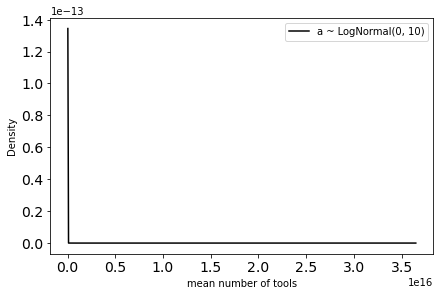

In [28]:
ax = az.plot_kde(
    pm.Lognormal.dist(0.0, 10.0).random(size=20_000),
    label="a ~ LogNormal(0, 10)",
    plot_kwargs={"color": "k"},
)
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

#### Huge spike at zero with meaning zero tools on average and a very long tail of size:

In [18]:
a = np.random.normal(0, 10, size=10_000)
_lambda = np.exp(a)
np.mean(_lambda)

4045382990278.7383

#### This is a lot of tools, we can do better than this. The fact to appreciate is that a log link puts half of the real numbers— the negative numbers—between 0 and 1 on the outcome scale. So if your prior puts half its mass below zero, then half the mass will end up between 0 and 1 on the outcome scale. For Poisson models, flat priors make no sense and can wreck havoc.

#### A weakly informative suggestion:

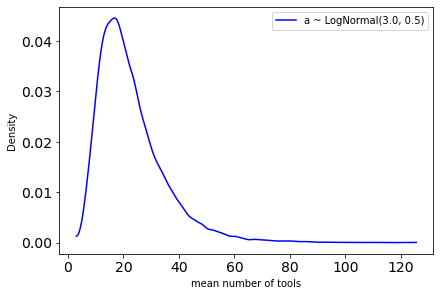

In [27]:
ax = az.plot_kde(
    pm.Lognormal.dist(3.0, 0.5).random(size=20_000),
    label="a ~ LogNormal(3.0, 0.5)",
    plot_kwargs={"color": "b"},
)
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

#### The mean is now exp(3 + 0.5 2/2) ≈ 20. We haven’t looked at the mean of the total_tools column, and we don’t want to. This is supposed to be a prior. We want the prior predictive distribution to live in the plausible outcome space, not fit the sample.

#### What about a prior for $\beta$, the coefficient of log population? Let's start with a flat prior $\beta \sim Normal(0, 10)$

In [46]:
def plot_priors(ax, N=100, beta_prior = (0, 10), x_scale="log"):
    intercept = np.random.normal(3, 0.5, N)
    location, scale = beta_prior
    
    slopes = np.random.normal(loc = location, scale = scale, size = N)
    ax.set_title(f"b ~ Normal({location}, {scale}")
    
    x_sequence = np.linspace(np.log(100), np.log(200_000), N)
    ax.set_ylim((0, 500))
    
    
    if x_scale=="log":
        for i, j in zip(intercept, slopes):
            ax.plot(x_sequence, np.exp(i + j * x_sequence), "k", alpha=0.5)
        ax.set_label("log population")
    elif x_scale == "natural":
        for i, j in zip(intercept, slopes):
            ax.plot(np.exp(x_sequence), np.exp(i + j * x_sequence), "k", alpha=0.5)
        ax.set_xlabel("population")
    else:
        x_sequence = np.linspace(-2, 2, N)
        for i,j in zip(intercept, slopes):
            ax.plot(x_sequence, np.exp(i + j * x_sequence), "k", alpha=0.5)
        ax.set_ylim((0, 100))
        ax.set_label("log population (std)")
    return ax

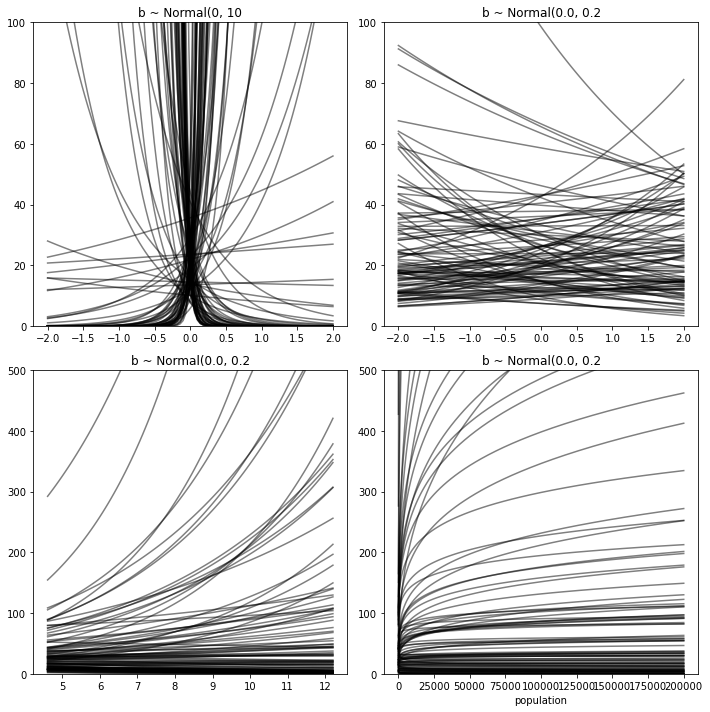

In [48]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_priors(ax[0][0], x_scale="std")
plot_priors(ax[0][1], beta_prior = (0.0, 0.2), x_scale="std")
plot_priors(ax[1][0], beta_prior = (0.0, 0.2), x_scale="log")
plot_priors(ax[1][1], beta_prior = (0.0, 0.2), x_scale="natural")
plt.tight_layout();

#### The original prior thinks that the vast majority of prior relationships between log population and total tools embody either explosive growth just above the mean log population size or rather catastrophic decline right before the mean. This prior is terrible. 

#### We also try a prior that is a lot tighter $\beta \sim Normal(0, 0.2)$

#### This plot is displayed in the top-right. Strong relationships are still possible, but most of the mass is for rather flat relationships between total tools and log population. It will also help to view these priors on more natural outcome scales. The standardized log population variable is good for fitting. But it is bad for thinking. Population size has a natural zero, and we want to keep that in sight. Standardizing the variable destroys that. 

#### This plot is displayed in the top-right of Figure 11.8. Strong relationships are still possible, but most of the mass is for rather flat relationships between total tools and log population. It will also help to view these priors on more natural outcome scales. The standardized log population variable is good for fitting. But it is bad for thinking. Population size has a natural zero, and we want to keep that in sight. Standardizing the variable destroys that

In [54]:
with pm.Model() as m11_9:
    a = pm.Normal("a", 3.0, 0.5)
    T = pm.Poisson("total_tools", pm.math.exp(a), observed = d.total_tools)
    
    trace_11_9 = pm.sample(tune=3_000, random_seed = 8_927)

<ipython-input-54-67929ac59682>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_9 = pm.sample(tune=3_000, random_seed = 8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 6 seconds.


In [59]:
P = d.P
cid = d.cid

with pm.Model() as m11_10:
    a = pm.Normal("a", 3.0, 0.5, shape=2)
    b = pm.Normal("b", 0.0, 0.2, shape=2)
    
    c_id = pm.intX(pm.Data("c_id", cid))
    P_ = pm.Data("P", P)
    
    _lambda = pm.math.exp(a[c_id] + b[c_id]*P_)
    
    T = pm.Poisson("total_tools", _lambda, observed = d.total_tools)
    
    trace_11_10 = pm.sample(tune=3_000, random_seed = 8_927)

<ipython-input-59-17a6ad91f2fa>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_10 = pm.sample(tune=3_000, random_seed = 8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 6 seconds.


#### Two models were constructed, an intercept only model and the full model specified above. We can do a comparison on the basis of PSIS.

In [60]:
az.compare({"m11_9": trace_11_9, "m11_10": trace_11_10})

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11_10,0,-42.938030,7.304072,0.000000,0.967217,6.328970,0.000000,True,log
m11_9,1,-71.011183,8.634768,28.073153,0.032783,16.098187,15.678144,True,log


In [61]:
pareto_k = az.loo(trace_11_10, pointwise=True).pareto_k.values

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


#### We get some expected problems (warning = True), this is a tiny dataset and probably has some highly leveraged points. The model is almost certainly overfitting. Let's examine the posteriors.

In [66]:
n = 100
P_sequence = np.linspace(-1.4, 3.0, n)

with m11_10:
    #cid = 0 posterior preds
    pm.set_data({"c_id": np.array([0]*n), "P": P_sequence})
    lambda_0 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]
    
    #cid = 1 posterior preds
    pm.set_data({"c_id": np.array([1]*n), "P": P_sequence})
    lambda_1 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]
    
l_mu_0, l_mu_1 = lambda_0.mean(0),  lambda_1.mean(1)
    

In [68]:
def plotter(ax, p_seq, _lambda, lambda_mu, lab, col):
    az.plot_hdi(p_seq, _lambda, color=col, fill_kwargs={"alpha": 0.2}, ax=ax)
    ax.plot(p_seq, lambda_mu, color=col, alpha=0.7, label=lab)

In [ ]:
n = 100
P_sequence = np.linspace(-1.4, 3.0, n)
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

# scale point size to Pareto-k:
pareto_k /= pareto_k.max()
psize = 250 * pareto_k

# Plot on standardized log scale:

az.plot_hdi(P_sequence, lambda_1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_sequence, l_mu_1, color="b", alpha=0.7, label="high contact mean")

az.plot_hdi(P_sequence, lambda_0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_sequence, l_mu_0, "--", color="k", alpha=0.7, label="low contact mean")

# display names and k:
mask = k > 0.3
labels = d.culture.values[mask]
for i, text in enumerate(labels):
    ax0.text(
        P[mask][i] - 0.2,
        d.total_tools.values[mask][i] + 4,
        f"{text} ({np.round(k[mask][i], 2)})",
        fontsize=8,
    )

# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    d.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(P[index], d.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
ax0.set_xlabel("log population (std)")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=8, ncol=2)

# Plot on natural scale:
# unstandardize and exponentiate values of standardized log pop:
P_seq = np.linspace(-5.0, 3.0, ns)
P_seq = np.exp(P_sequence * np.log(d.population.values).std() + np.log(d.population.values).mean())

az.plot_hdi(P_sequence, lambda_1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_sequence, l_mu_1, color="b", alpha=0.7)

az.plot_hdi(P_sequence, lambda_0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_sequence, l_mu_0, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    d.population[~index],
    d.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(d.population[index], d.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools")
plt.tight_layout();

#### The above isn't quite working, it should produce the following:

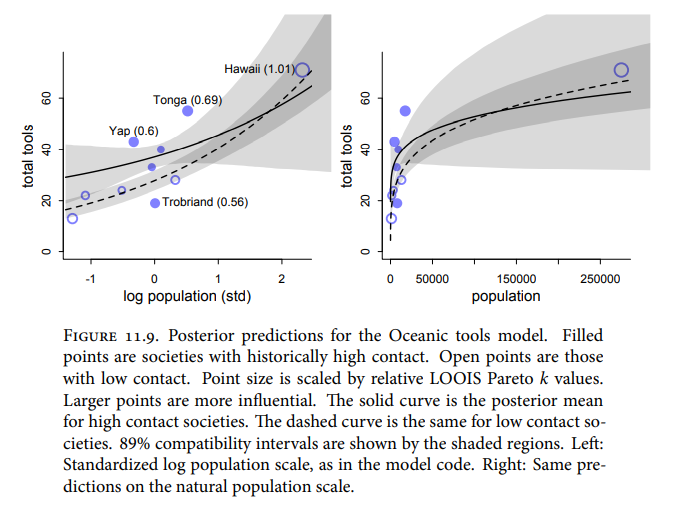

In [83]:
display(Image.open(os.path.join(os.getcwd(),r'data/poisson1.png')))

#### Hawaii (k = 1.01), Tonga (k = 0.69), Tap (k = 0.6), and the Trobriand Islands (k = 0.56) are highly influential points. Most are not too influential, but Hawaii is very influential. You can see why in the figure: It has extreme population size and the most tools. This is most obvious on the natural scale. This doesn’t mean Hawaii is some “outlier” that should be dropped from the data.

#### Another approach is to build a toy model based on scientific knowledge. This model is a dynamic one for the cultural evolution of tools. Tools develop over time subject to innovation and loss. These forces blend to produce tool kits of difference sizes. Assume innovation is proportional to population size with some diminishing returns and assume tool loss is proportional to the number of tools, with no diminishing returns then:
$$\Delta T = \alpha P^{\beta} - \gamma T$$

#### Where $P$ is the population size, $T$ is the number of tools and $\alpha$, $\beta$ and $\gamma$ are params to be estimated. To find an equilibrium number of tools, set $\Delta T = 0$ and solve for $T$:

$$ \bar{T} = \alpha P^{\beta} / \gamma$$ 

#### We can estimate the following model with no link function (we just have to ensure that $\lambda$ is positive:

$$T_{i} \sim Poisson(\lambda_{i})$$

#### $$\lambda_{i} = \alpha P^{\beta}_{i}/\gamma$$

In [84]:
def std(x):
    return (x - np.mean(x))/np.std(x)

P = std(np.log(d.population)).values
P = P + np.abs(P.min()) + 0.1 #to ensure P is positive

In [88]:
with pm.Model() as m11_11:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)
    
    c_id = pm.intX(pm.Data("c_id", cid))
    P_ = pm.Data("P", P)
    lam = (tt.exp(a[c_id])*P_**b[c_id])/g
    
    T = pm.Poisson("total_tools", lam, observed=d.total_tools)
    trace_11_11 = pm.sample(2_000, tune=2_000, target_accept=0.9, random_seed = 8_927)

<ipython-input-88-fb21f384b4a5>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_11 = pm.sample(2_000, tune=2_000, target_accept=0.9, random_seed = 8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'g'}>]], dtype=object)

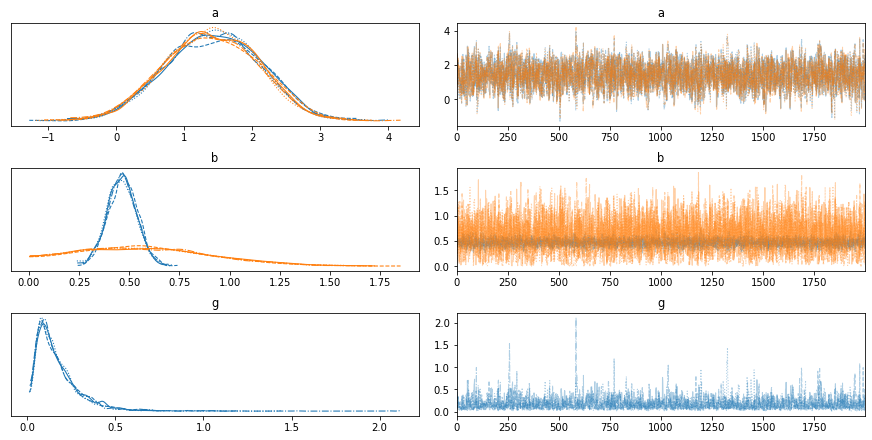

In [89]:
az.plot_trace(trace_11_11, compact=True)